# Klima DAO Treasury Total Carbon

## Dependencies

In [1]:
%matplotlib inline
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Get latest Klima data from Dune Analytics API

In [2]:
from duneanalytics import DuneAnalytics

# insert your username and API key here
dune = DuneAnalytics('username', 'apikey')

# try to login
dune.login()

# fetch token
dune.fetch_auth_token()

# get result id 
result_id = dune.query_result_id(query_id=209140)

# fetch query result
results = dune.query_result(result_id)

{'data': {'get_result': {'job_id': None, 'result_id': '69cc3d5c-b638-4b52-9388-36c4f8af7ba1', '__typename': 'get_result_response'}}}
{'data': {'query_results': [{'id': '69cc3d5c-b638-4b52-9388-36c4f8af7ba1', 'job_id': '3a52ab05-d5f7-45af-9d35-5dcaf7c8e22d', 'error': None, 'runtime': 27, 'generated_at': '2022-01-17T15:43:54.595256+00:00', 'columns': ['date', 'total_bct', 'reserve_bct', 'reserve_mco2', 'klima_bct_lp', 'bct_usdc_lp'], '__typename': 'query_results'}], 'get_result_by_result_id': [{'data': {'bct_usdc_lp': 4573636.284750217, 'date': '2022-01-17T00:00:00+00:00', 'klima_bct_lp': 2886739.2921622875, 'reserve_bct': 7579229.887784503, 'reserve_mco2': 33442.34307758718, 'total_bct': 15047013.007347122}, '__typename': 'get_result_template'}, {'data': {'bct_usdc_lp': 4376945.327601852, 'date': '2022-01-16T00:00:00+00:00', 'klima_bct_lp': 3064742.996419914, 'reserve_bct': 7572570.169234128, 'reserve_mco2': 32754.535575094953, 'total_bct': 15020177.42257129}, '__typename': 'get_result_

In [3]:
# convert results to a DataFrame
df_klima = pd.DataFrame.from_records([i['data'] for i in results['data']['get_result_by_result_id']])
df_klima['date'] = pd.to_datetime(df_klima['date'])
df_klima.sort_values(by='date', inplace=True)
df_klima.tail()

,bct_usdc_lp,date,klima_bct_lp,reserve_bct,reserve_mco2,total_bct
4,4.185621e+06,2022-01-13 00:00:00+00:00,3.200998e+06,7.299192e+06,19724.862695,1.467242e+07
3,4.211272e+06,2022-01-14 00:00:00+00:00,3.167482e+06,7.393845e+06,24866.190703,1.477384e+07
2,4.190766e+06,2022-01-15 00:00:00+00:00,3.135225e+06,7.480280e+06,31360.424470,1.481151e+07
1,4.376945e+06,2022-01-16 00:00:00+00:00,3.064743e+06,7.572570e+06,32754.535575,1.502018e+07
0,4.573636e+06,2022-01-17 00:00:00+00:00,2.886739e+06,7.579230e+06,33442.343078,1.504701e+07


## Simple visualization of the Klima data

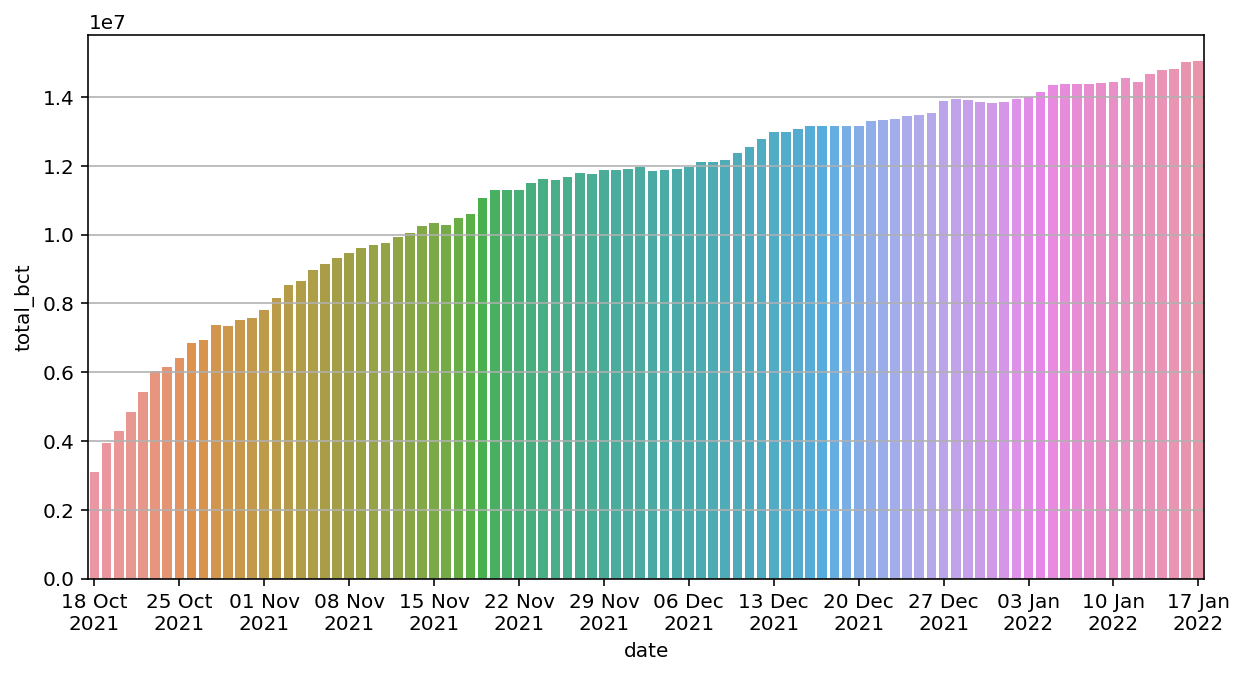

In [4]:
fig, ax = plt.subplots(figsize=(10,5), dpi=144)
sns.barplot(data=df_klima, x='date', y='total_bct', ax=ax)

x_dates = df_klima['date'].dt.strftime('%d %b\n%Y').unique()
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=3, interval=1))

ax.yaxis.grid()

## Pull the Country CO2 emissions data from Our World in Data

In [5]:
url = 'https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv'
owd_data = pd.read_csv(url)

In [6]:
# only include valid countries
df_owd = owd_data[owd_data['iso_code'].apply(lambda x: len(x)==3 if isinstance(x, str) else False)]

# only include 2020 data
df_owd = df_owd.query("year == 2020")

# remove data we don't need
df_owd = df_owd[['country', 'co2']].dropna()

# sort
df_owd.sort_values(by='co2', inplace=True)

df_owd.head()

,country,co2
23251,Tuvalu,0.008
19208,Saint Helena,0.009
16202,Niue,0.011
15076,Montserrat,0.025
19390,Saint Pierre and Miquelon,0.051


## Set Y tick marks to the closest country's emissions

In [7]:
ymin = df_klima['total_bct'].min()
ymax = df_klima['total_bct'].max()
yrange = list(np.linspace(ymin, ymax, 11) / 1000000)

yticks = []
labels = []
for y in yrange:
    match = df_owd.iloc[(df_owd['co2']-y).abs().argsort()[:1]]
    val = match['co2'].item()
    cty = match['country'].item()
    lbl = f"{cty} ({val:.1f}M tons)"
    yticks.append(val)
    labels.append(lbl)
labels

['Congo (3.1M tons)',
 'Gabon (4.3M tons)',
 'Moldova (5.1M tons)',
 'Papua New Guinea (6.7M tons)',
 'Costa Rica (7.9M tons)',
 'New Caledonia (8.7M tons)',
 'Equatorial Guinea (10.3M tons)',
 'Kyrgyzstan (11.5M tons)',
 'Slovenia (12.6M tons)',
 'Lithuania (13.8M tons)',
 'Cambodia (15.3M tons)']

## Make the chart

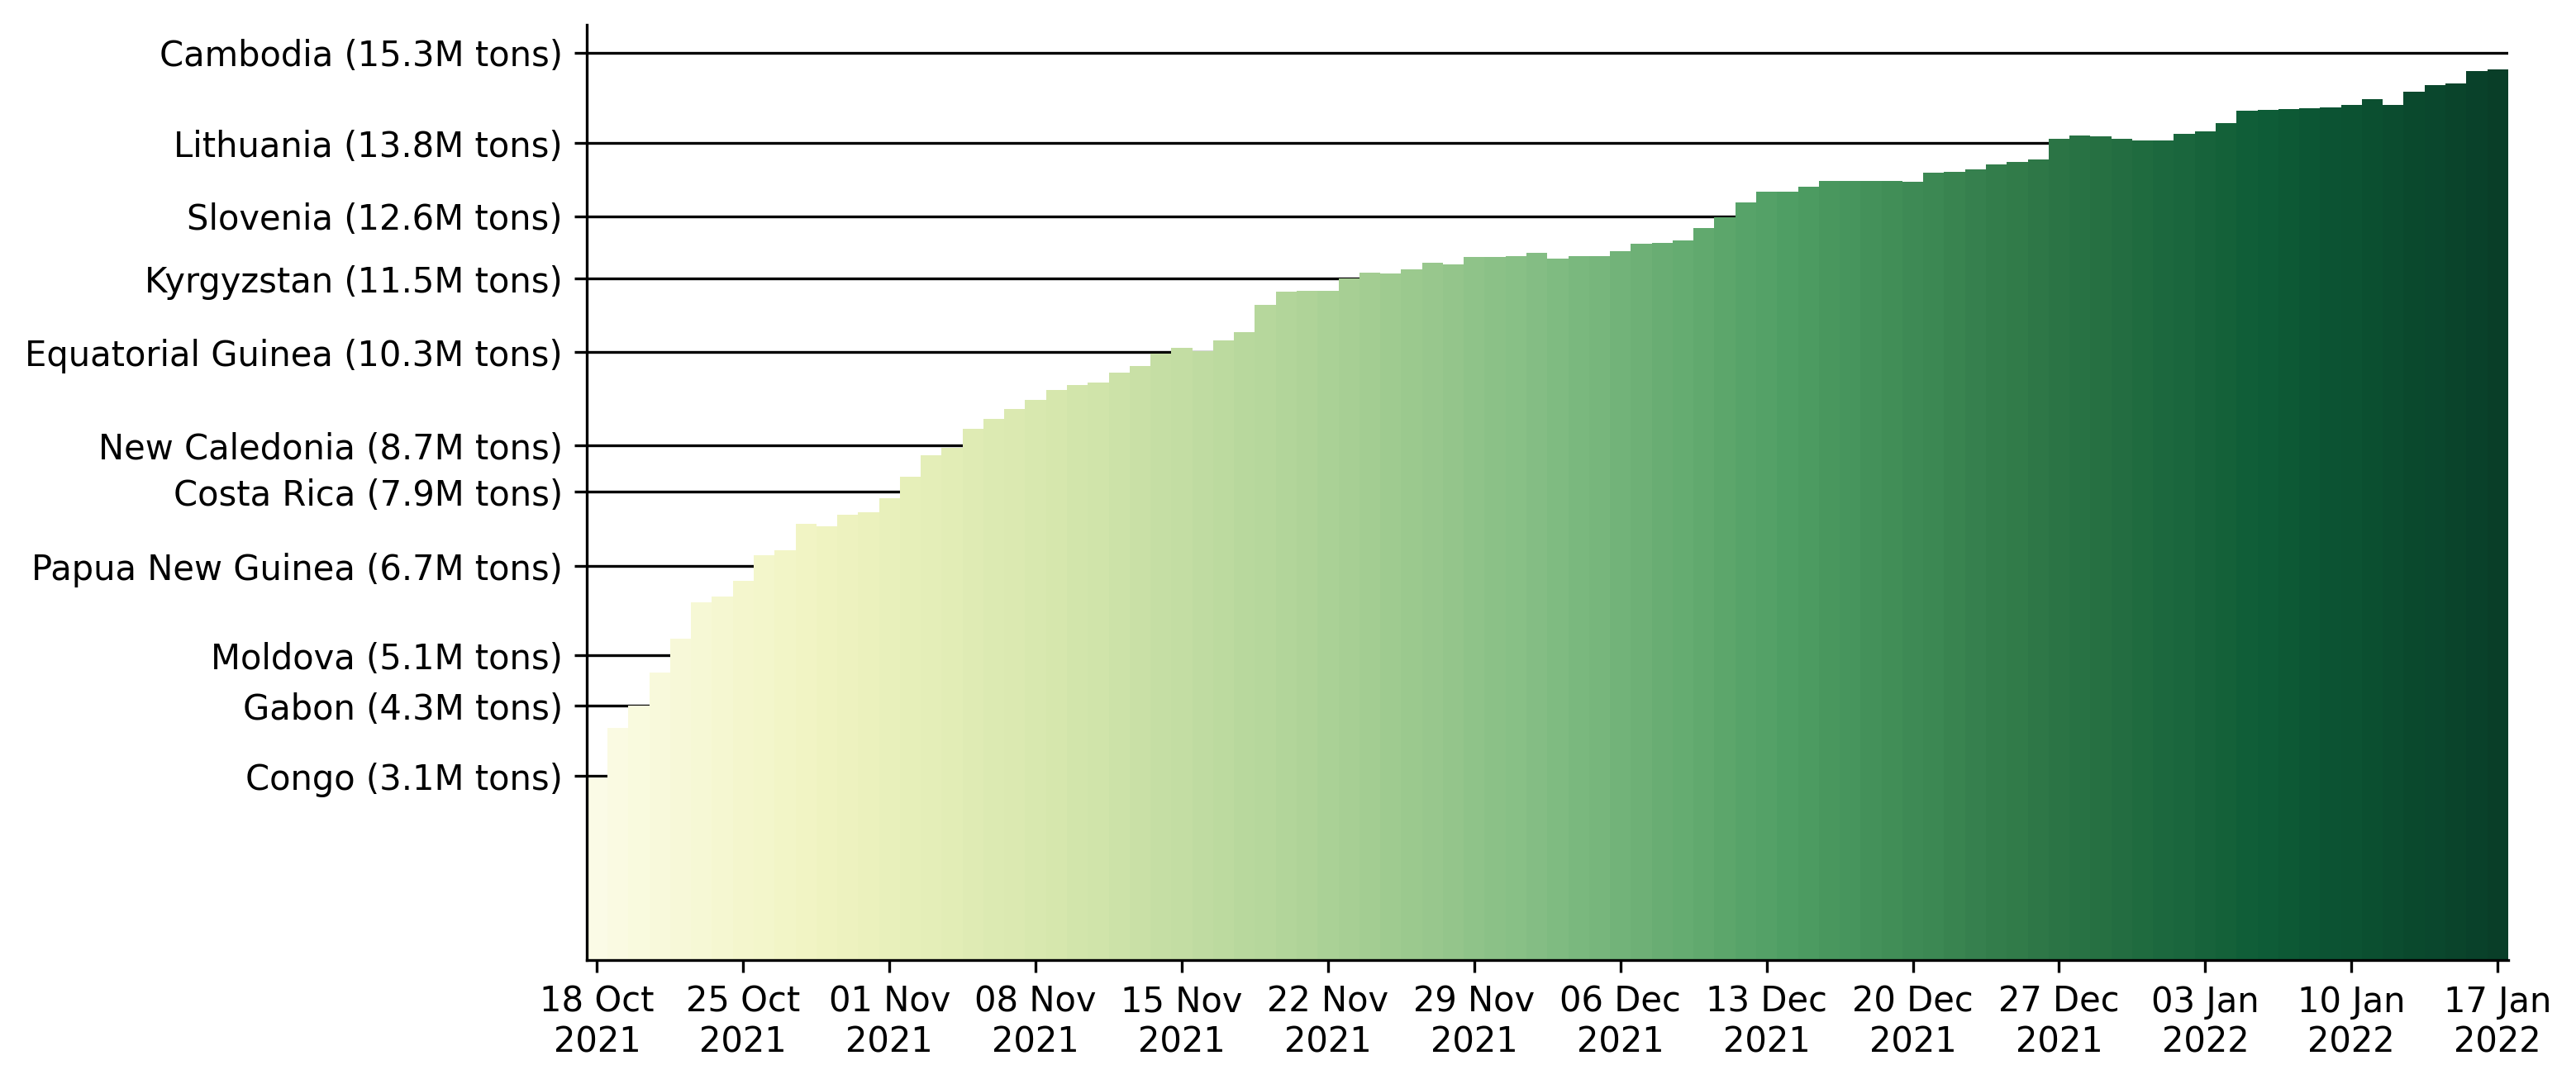

In [8]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.barplot(data=df_klima, x='date', y='total_bct', ax=ax, palette='YlGn', dodge=2)

x_dates = df_klima['date'].dt.strftime('%d %b\n%Y').unique()
ax.set_xticklabels(labels=x_dates, rotation=0, ha='center')
ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=3, interval=1))
ax.set_xlabel('')

ax.set_yticks([y*1000000 for y in yticks])
ax.set_yticklabels(labels)
ax.set_ylabel('')

ax.yaxis.grid(zorder=0, color='black')
ax.set_axisbelow(True)

new_value = 1
for patch in ax.patches:
    current_width = patch.get_width()
    diff = current_width - new_value

    #change the bar width
    patch.set_width(new_value)

    #recenter the bar
    patch.set_x(patch.get_x() + diff * .5)
    
    
#ax.set_title("Klima DAO\nTotal Carbon Tons in Locked in Treasury vs Annual Emissions of Selected Countries")    
sns.despine()    